In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

# Batching

> This feature is still in Beta and will likly evolve based on user feedback.

An advanced feature of flow diagrams is that they support async batching of operations.
These means that if we want to process a list of tasks asynchronously, we dont have to write a node that processes the list.

Instead, we write a node that processes a single item, and instruct stringdale to run our function on every item of a list in our input seperately.

In [ ]:
import asyncio
from stringdale.diagrams import (
    Define,
    V,
    E,
)

In [ ]:
async def async_add(a,b,c):
    await asyncio.sleep(0.1)
    return a+b+c

class Range:
    def __init__(self,length,step=1):
        self.length = length
        self.step = step
    def __call__(self,initial_value=0):
        return list(range(initial_value,initial_value+self.length*self.step,self.step))
    def __str__(self):
        return f'Range({self.length},{self.step})'


## For_Each

We can define a diagram as follows:

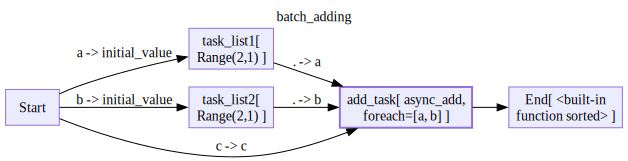

In [ ]:
with Define('batch_adding',direction='LR') as D:
    V('task_list1',Range(2),inputs=['Start(initial_value=a)'])
    V('task_list2',Range(2),inputs=['Start(initial_value=b)'])
    V('add_task',async_add,
        inputs=['task_list1(a=.)','task_list2(b=.)','Start(c=c)'],
        # for each is a list of input ports to map the function on
        # in this case, we have input ports a,b and c
        # a and b are for each, so we will run async_add for each combination of item from a and item from b
        # c is not in for_each, so it will be the same for each run
        for_each=['a','b'])
    
    # since async_add is now a foreach node, it will be called multiple times and the results will be collected into a list
    # before being fed into a regular node
    # we can sort the list to make sure that the results are deterministic
    V('End',sorted,inputs=['add_task'])

In [ ]:
d=D()
for trace in d.run({'a':1000,'b':100,'c':10}):
    trace.pprint()


Node Start:
{ 'input': {'a': 1000, 'b': 100, 'c': 10},
  'output': {'a': 1000, 'b': 100, 'c': 10}}
Node task_list2:
{'input': {'initial_value': 100}, 'output': [100, 101]}
Node task_list1:
{'input': {'initial_value': 1000}, 'output': [1000, 1001]}
Node add_task[1]:
{'input': {'a': 1000, 'b': 101, 'c': 10}, 'output': 1111}
Node add_task[0]:
{'input': {'a': 1000, 'b': 100, 'c': 10}, 'output': 1110}
Node add_task[2]:
{'input': {'a': 1001, 'b': 100, 'c': 10}, 'output': 1111}
Node add_task[3]:
{'input': {'a': 1001, 'b': 101, 'c': 10}, 'output': 1112}
Node End:
{'input': {0: [1111, 1110, 1111, 1112]}, 'output': [1110, 1111, 1111, 1112]}


## Flat

Working with lists and lists of lists can get out of hand quickly. We also supply a `flat` that will flatten out nested lists

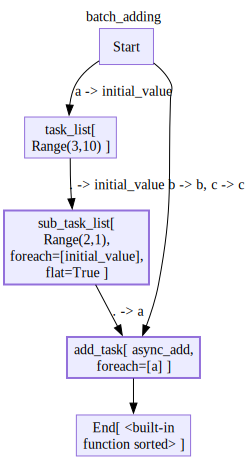

In [ ]:
with Define('batch_adding',direction='TB') as D:
    V('task_list',Range(3,step=10),inputs=['Start(initial_value=a)'])
    
    V('sub_task_list',Range(2),
        inputs=['task_list(initial_value=.)'],
        for_each=['initial_value'],
        # Since Range returns lists, and it is a foreach node, the output of this node will be a list of lists
        # flat=True will flatten this list of lists into a single list
        flat=True)
    
    V('add_task',async_add,
        inputs=['sub_task_list(a=.)','Start(b=b,c=c)'],
        for_each=['a'],)
    
    # since async_add is now a foreach node, it will be called multiple times and the results will be collected into a list
    V('End',sorted,inputs=['add_task'])

In [ ]:
d= D()
for trace in d.run({'a':1000,'b':0,'c':0}):
    trace.pprint()


Node Start:
{'input': {'a': 1000, 'b': 0, 'c': 0}, 'output': {'a': 1000, 'b': 0, 'c': 0}}
Node task_list:
{'input': {'initial_value': 1000}, 'output': [1000, 1010, 1020]}
Node sub_task_list[0]:
{'input': {'initial_value': 1000}, 'output': [1000, 1001]}
Node sub_task_list[2]:
{'input': {'initial_value': 1020}, 'output': [1020, 1021]}
Node sub_task_list[1]:
{'input': {'initial_value': 1010}, 'output': [1010, 1011]}
Node add_task[1]:
{'input': {'a': 1001, 'b': 0, 'c': 0}, 'output': 1001}
Node add_task[0]:
{'input': {'a': 1000, 'b': 0, 'c': 0}, 'output': 1000}
Node add_task[4]:
{'input': {'a': 1010, 'b': 0, 'c': 0}, 'output': 1010}
Node add_task[3]:
{'input': {'a': 1021, 'b': 0, 'c': 0}, 'output': 1021}
Node add_task[2]:
{'input': {'a': 1020, 'b': 0, 'c': 0}, 'output': 1020}
Node add_task[5]:
{'input': {'a': 1011, 'b': 0, 'c': 0}, 'output': 1011}
Node End:
{ 'input': {0: [1001, 1000, 1010, 1021, 1020, 1011]},
  'output': [1000, 1001, 1010, 1011, 1020, 1021]}


## Batching beyond stringdale

At the moment stringdale's batching is far from comprehensive.
But this shouldn't limit you. Not all of your logic needs to be in stringdale.

Let us look at the following example. Lets say you are building a batch server and you would like to:
* Process items every time you have 2 pending requests.
* Send items to storage in batches of 3

Here are some mocks for our ingress and egress logic

In [ ]:
class InputQueue:
    def __init__(self,items):
        self.items = items
    async def chunk(self):
        # imagine that you are listening to a queue
        # yield each 2 items as a list, pop them from the queue
        while len(self.items) >= 2:
            await asyncio.sleep(0.1)
            yield [self.items.pop(0),self.items.pop(0)]
        if len(self.items) == 1:
            await asyncio.sleep(0.1)
            yield [self.items.pop(0)]

class OutputQueue:
    def __init__(self):
        self.items = []
        self.upload_tasks = []  # Store pending upload tasks
        self.processed_batches = []
        
    async def add(self, add_batch):
        self.items.extend(add_batch)
        
        if len(self.items) >= 3:
            to_upload = [self.items.pop(0), self.items.pop(0), self.items.pop(0)]
            # Create upload task but don't await it
            upload_task = asyncio.create_task(self.upload(to_upload))
            self.upload_tasks.append(upload_task)
        return
        
    async def upload(self, add_batch):
        # implement your upload logic here
        await asyncio.sleep(0.1)
        self.processed_batches.append(add_batch)
        return True
        
    async def wait_for_uploads(self):
        # Optional: Method to wait for all pending uploads to complete
        if self.upload_tasks:
            await asyncio.gather(*self.upload_tasks)
            self.upload_tasks.clear()

Given a diagram that iterates over a single item.

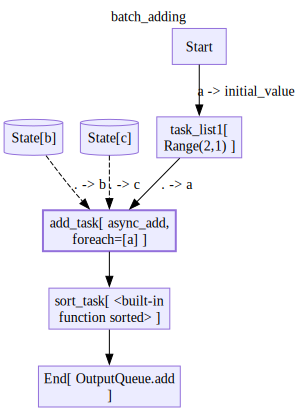

In [ ]:
input_queue = InputQueue([1,2,3,4,5,6,7,8,9,10])
output_queue = OutputQueue()

with Define('batch_adding',direction='TB') as D:
    V('task_list1',Range(2),inputs=['Start(initial_value=a)'])
    V('add_task',async_add,
        inputs=['task_list1(a=.)','state/b(b=.)','state/c(c=.)'],
        for_each=['a'])

    V('sort_task',sorted,inputs=['add_task'])
    
    V('End',output_queue.add,inputs=['sort_task'])

We can run it like so:

In [ ]:
d= D()

async for batch in input_queue.chunk():
    for item in batch:
        async for trace in d.arun({'a':item},state={'b':0,'c':0}):
            pass # send traces to log server

await output_queue.wait_for_uploads()
output_queue.processed_batches,output_queue.items

([], [])